In [1]:
import sys
import os

# Adjust the sys.path to include the src directory
current_dir = os.getcwd()
sys.path.append(os.path.abspath(os.path.join(current_dir, '../..', '')))
print("Path setup complete.")

Path setup complete.


In [2]:
import numpy as np
import yads.mesh as ym
from yads.wells import Well

from yads.numerics.physics import calculate_transmissivity

# Problem configuration

In [3]:
nb_cells = 201
grid = ym.two_D.create_2d_cartesian(50 * 200, 1000, 201, 1)

In [4]:
phi = 0.2
# Porosity
phi = np.full(grid.nb_cells, phi)
# Diffusion coefficient (i.e Permeability)
K = np.full(grid.nb_cells, 100.0e-15)
# gaz saturation initialization
S = np.full(grid.nb_cells, 0.0)
# Pressure initialization
P = np.full(grid.nb_cells, 100.0e5)

T = calculate_transmissivity(grid, K)

# viscosity
mu_w = 0.571e-3
mu_g = 0.0285e-3

kr_model = "quadratic"
# BOUNDARY CONDITIONS #
# Pressure
Pb = {"left": 110.0e5, "right": 100.0e5}

# Saturation
Sb_d = {"left": 0.0, "right": 0.0}
Sb_n = {"left": None, "right": None}
Sb_dict = {"Dirichlet": Sb_d, "Neumann": Sb_n}

V = grid.measures(item="cell")

## Well configuration

In [5]:
import pandas as pd

In [6]:
test = pd.read_csv(
        "hybrid_newton_data/test.csv",
        sep="\t",
    )

In [7]:
test["log_q"] = -np.log10(-test["q"])
test["log_dt"] = np.log(test["dt"])

In [8]:
sample_index = 42

qt = test[["q", "dt"]].loc[sample_index].to_numpy()
log_qt = test[["log_q", "log_dt"]].loc[sample_index].to_numpy()
print(qt)

[-9.40000000e-05  1.06102294e+08]


In [9]:
well_co2 = Well(
    name="well co2",
    cell_group=np.array([[5000.0, 500]]),
    radius=0.1,
    control={"Neumann": qt[0]},
    s_inj=1.0,
    schedule=[
        [0.0, qt[1]],
    ],
    mode="injector",
)

In [10]:
max_newton_iter = 200
eps = 1e-6

# Standard initial guess

In [11]:
from yads.numerics.schemes.solss import solss
from hybrid_newton_inference import hybrid_newton_inference
from yads.numerics.solvers import implicit_pressure_solver

In [12]:
P_imp_global = implicit_pressure_solver(
    grid=grid,
    K=K,
    T=T,
    P=P,
    S=S,
    Pb=Pb,
    Sb_dict=Sb_dict,
    mu_g=mu_g,
    mu_w=mu_w,
    kr_model=kr_model,
    wells=[well_co2],
)

In [13]:
P_i_plus_1, S_i_plus_1, dt_sim, nb_newton, norms = hybrid_newton_inference(
        grid=grid,
        P=P_imp_global,
        S=S,
        Pb=Pb,
        Sb_dict=Sb_dict,
        phi=phi,
        K=K,
        mu_g=mu_g,
        mu_w=mu_w,
        dt_init=qt[1],
        kr_model=kr_model,
        max_newton_iter=max_newton_iter,
        eps=1e-6,
        wells=[well_co2],
        P_guess=P_imp_global,
        S_guess=S,
    )

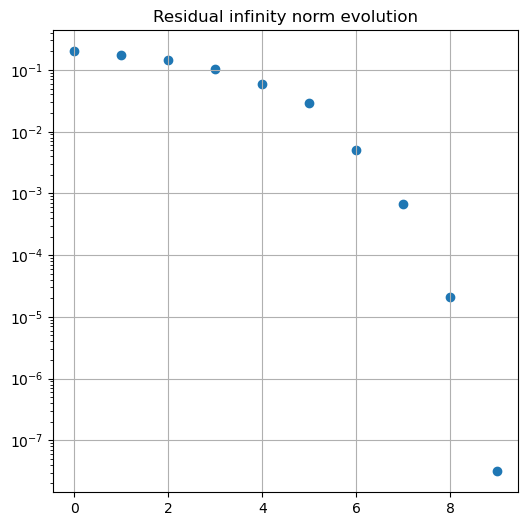

In [14]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1,1, figsize=(6, 6))
axs.scatter(range(int(nb_newton) + 1), norms['L_inf'])
axs.grid()
axs.set_yscale('log')
axs.set_title("Residual infinity norm evolution")
plt.show()

# Hybrid initial guess

In [15]:
import torch
import pickle 

from ml_tools.FNO1D import FNO1d
from ml_tools.UnitGaussianNormalizer import UnitGaussianNormalizer

In [16]:
S_model = FNO1d(modes=12, width=64, n_features=4)
S_model.load_state_dict(
    torch.load(
        "hybrid_newton_data/best_FNO1D_PS.pt",
        map_location=torch.device("cpu"),
    )
)

q_normalizer = pickle.load(
    open("hybrid_newton_data/GWM_q_normalizer.pkl", "rb")
)
dt_normalizer = pickle.load(
    open("hybrid_newton_data/GWM_dt_normalizer.pkl", "rb")
)
P_imp_normalizer = pickle.load(
    open("hybrid_newton_data/GWM_P_imp_normalizer.pkl", "rb")
)

/var/folders/lb/7819f89d69v17j4h5j74p8kc0000gp/T/ipykernel_3851/857158628.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(


## Building new initial guess

In [17]:
q_flat_zeros = np.zeros(nb_cells)
q_flat_zeros[100] = log_qt[0]

log_q = torch.from_numpy(np.array(np.reshape(q_flat_zeros, (nb_cells, 1))))
log_dt = torch.from_numpy(np.array(np.full((nb_cells, 1), log_qt[1])))
S0 = torch.from_numpy(np.array(np.zeros((nb_cells, 1))))
log_P_imp = torch.from_numpy(
    np.array(np.log10(np.array(P_imp_global).reshape(nb_cells, 1)))
)

log_q = q_normalizer.encode(log_q).float()
log_dt = dt_normalizer.encode(log_dt).float()
log_P_imp = P_imp_normalizer.encode(log_P_imp).float()

x = torch.cat([log_q, log_dt, S0, log_P_imp], 1).float()

# normalizer prep

x = x.reshape(1, nb_cells, 4)

S_pred_global = S_model(x)
S_pred_global = S_pred_global.detach()
S_pred_global = S_pred_global.reshape(nb_cells)

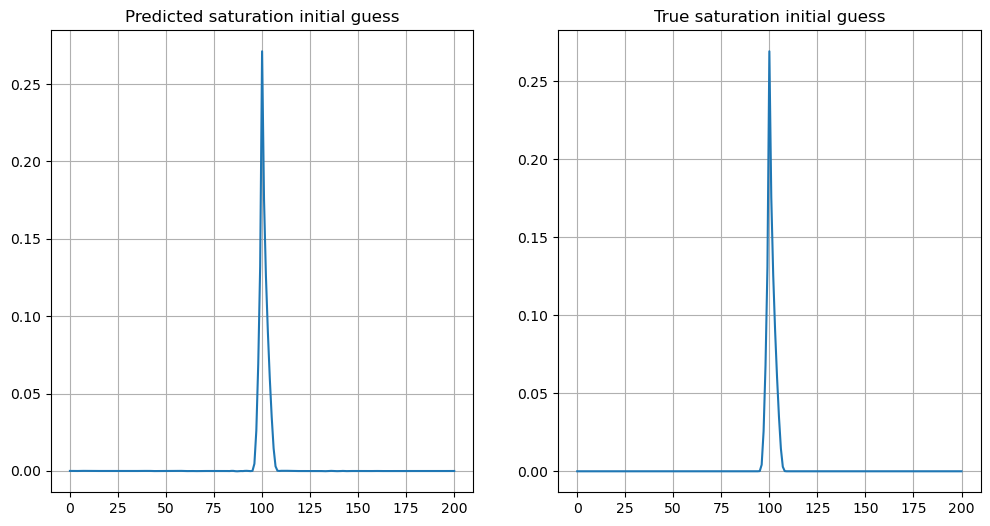

In [18]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

axs[0].plot(S_pred_global)
axs[1].plot(S_i_plus_1)

axs[0].set_title("Predicted saturation initial guess")
axs[1].set_title("True saturation initial guess")

axs[0].grid()
axs[1].grid()
plt.show()

In [19]:
P_i_plus_1, S_i_plus_1, dt_sim, hybrid_nb_newton, hybrid_norms = hybrid_newton_inference(
    grid=grid,
    P=P_imp_global,
    S=S,
    Pb=Pb,
    Sb_dict=Sb_dict,
    phi=phi,
    K=K,
    mu_g=mu_g,
    mu_w=mu_w,
    dt_init=qt[1],
    kr_model=kr_model,
    max_newton_iter=max_newton_iter,
    eps=1e-6,
    wells=[well_co2],
    P_guess=P_imp_global,
    S_guess=S_pred_global,
)

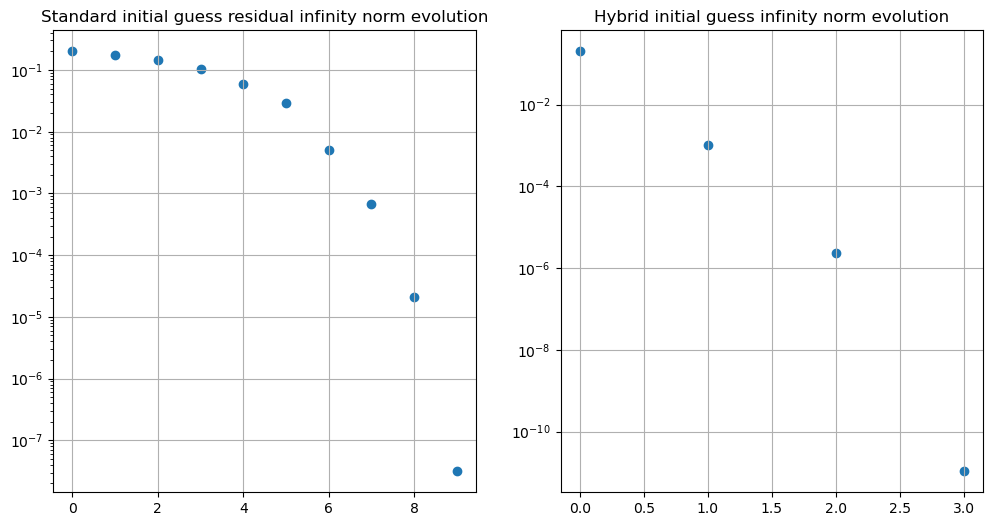

In [20]:
fig, axs = plt.subplots(1,2, figsize=(12, 6))
axs[0].scatter(range(int(nb_newton) + 1), norms['L_inf'])
axs[0].grid()
axs[0].set_yscale('log')
axs[0].set_title("Standard initial guess residual infinity norm evolution")

axs[1].scatter(range(int(hybrid_nb_newton) + 1), hybrid_norms['L_inf'])
axs[1].grid()
axs[1].set_yscale('log')
axs[1].set_title("Hybrid initial guess infinity norm evolution")

plt.show()
